C:\Users\siric\AppData\Local\Temp\ipykernel_32724\114367928.py:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['timestamp'] = pd.date_range(start='2025-09-06 00:00:00', periods=len(data), freq='T')
C:\Users\siric\AppData\Local\Temp\ipykernel_32724\114367928.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['timestamp'] = pd.date_range(start='2025-09-06 00:00:00', periods=len(data), freq='T')
C:\Users\siric\AppData\Local\Temp\ipykernel_32724\114367928.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'pressure_lag_{i}'] = data['pressure'].shift(i).fillna(method='bfill')
C:\Users\siric\AppData

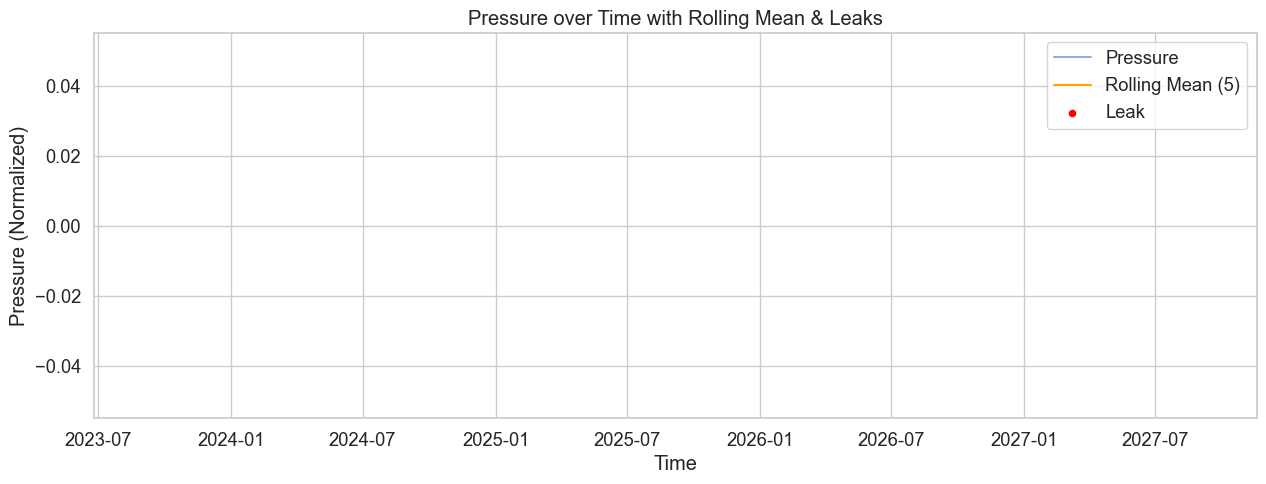

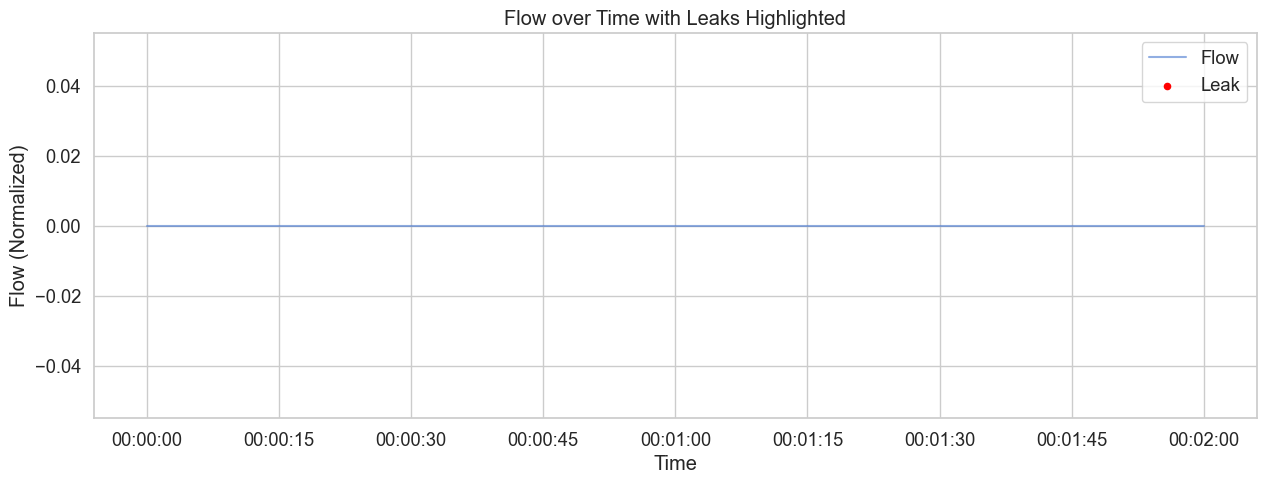

c:\Mini_Project_4-1\smart-water-plus\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Mini_Project_4-1\smart-water-plus\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


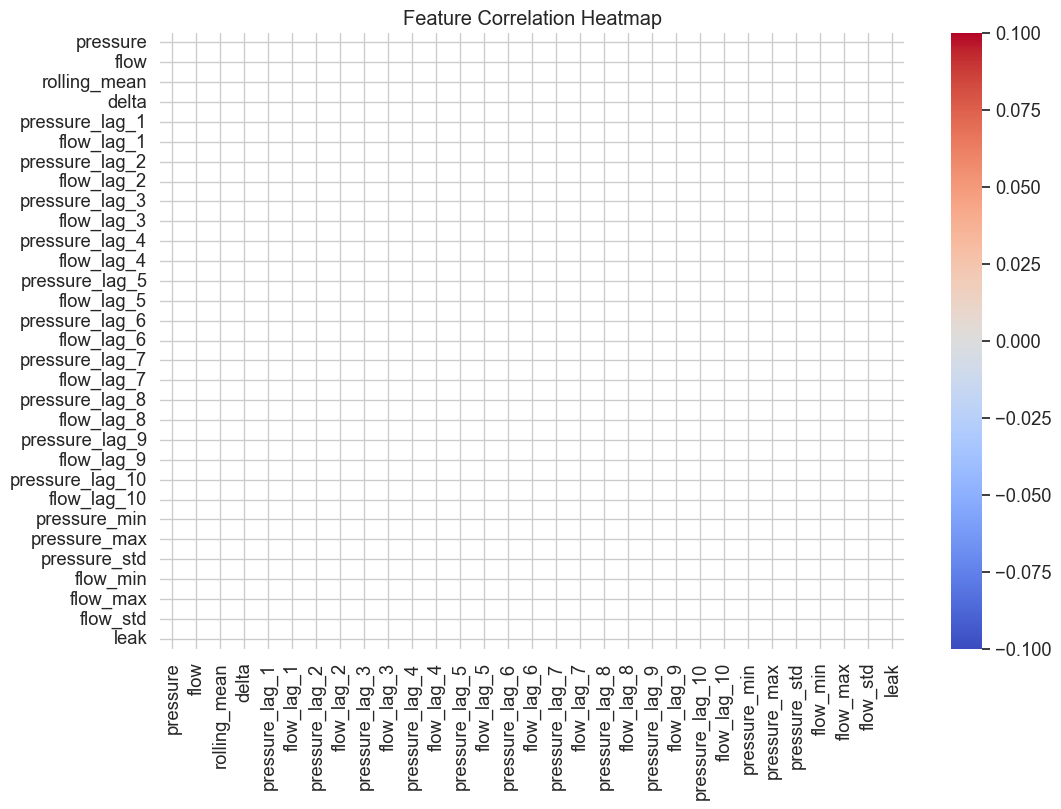

✅ Full ML-ready dataset preparation complete!
Train shape: (2, 31), Test shape: (1, 31)


c:\Mini_Project_4-1\smart-water-plus\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Mini_Project_4-1\smart-water-plus\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


✅ All plots saved to docs/img/ for documentation


In [8]:
# /simulation/data_prep.ipynb

# ------------------------------
# Step 1: Import libraries
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 2: Load all CSVs
files = glob.glob("simulation/data/*.csv")
df_list = [pd.read_csv(f) for f in files]
data = pd.concat(df_list, ignore_index=True)

# ------------------------------
# Step 2.1: Clean column names
data.columns = data.columns.str.strip()  # remove leading/trailing spaces

# ------------------------------
# Step 2.2: Convert numeric columns safely
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # invalid strings → NaN

# ------------------------------
# Step 3: Generate timestamp column (assume 1 reading per minute)
data['timestamp'] = pd.date_range(start='2025-09-06 00:00:00', periods=len(data), freq='T')
data = data.set_index('timestamp').sort_index()

# ------------------------------
# Step 4: Combine cluster pressures & flows
pressure_cols = [c for c in data.columns if 'Pressure' in c and pd.api.types.is_numeric_dtype(data[c])]
flow_cols = [c for c in data.columns if 'Demand' in c and pd.api.types.is_numeric_dtype(data[c])]

# Aggregate features
data['pressure'] = data[pressure_cols].mean(axis=1)   # average pressure
data['flow'] = data[flow_cols].sum(axis=1)           # total flow

# Optional: drop original cluster columns to reduce clutter
data = data[['pressure', 'flow']]

# ------------------------------
# Step 5: Handle missing values
data = data.interpolate(method='time')  # interpolate missing numeric values

# ------------------------------
# Step 6: Feature Engineering

# Rolling & delta features
data['rolling_mean'] = data['pressure'].rolling(window=5, min_periods=1).mean()
data['delta'] = data['pressure'].diff().fillna(0)

# Lag features (1–10 previous readings)
lag_features = 10
for i in range(1, lag_features + 1):
    data[f'pressure_lag_{i}'] = data['pressure'].shift(i).fillna(method='bfill')
    data[f'flow_lag_{i}'] = data['flow'].shift(i).fillna(method='bfill')

# Windowed aggregates
window_size = 5
data['pressure_min'] = data['pressure'].rolling(window=window_size, min_periods=1).min()
data['pressure_max'] = data['pressure'].rolling(window=window_size, min_periods=1).max()
data['pressure_std'] = data['pressure'].rolling(window=window_size, min_periods=1).std().fillna(0)

data['flow_min'] = data['flow'].rolling(window=window_size, min_periods=1).min()
data['flow_max'] = data['flow'].rolling(window=window_size, min_periods=1).max()
data['flow_std'] = data['flow'].rolling(window=window_size, min_periods=1).std().fillna(0)

# ------------------------------
# Step 7: Normalize numerical columns
num_cols = ['pressure', 'flow', 'rolling_mean', 'delta',
            'pressure_min', 'pressure_max', 'pressure_std',
            'flow_min', 'flow_max', 'flow_std'] + \
           [f'pressure_lag_{i}' for i in range(1, lag_features+1)] + \
           [f'flow_lag_{i}' for i in range(1, lag_features+1)]

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ------------------------------
# Step 8: Automated leak detection
pressure_threshold = data['pressure'].mean() - 2 * data['pressure'].std()
data['leak'] = (data['pressure'] < pressure_threshold).astype(int)

# ------------------------------
# Step 9: Visualizations (optional but professional)
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Pressure over time
plt.figure(figsize=(15,5))
plt.plot(data.index, data['pressure'], label='Pressure', alpha=0.6)
plt.plot(data.index, data['rolling_mean'], label='Rolling Mean (5)', color='orange')
plt.scatter(data.index[data['leak']==1], data['pressure'][data['leak']==1],
            color='red', label='Leak', s=20)
plt.title("Pressure over Time with Rolling Mean & Leaks")
plt.xlabel("Time")
plt.ylabel("Pressure (Normalized)")
plt.legend()
plt.show()

# Flow over time
plt.figure(figsize=(15,5))
plt.plot(data.index, data['flow'], label='Flow', alpha=0.6)
plt.scatter(data.index[data['leak']==1], data['flow'][data['leak']==1],
            color='red', label='Leak', s=20)
plt.title("Flow over Time with Leaks Highlighted")
plt.xlabel("Time")
plt.ylabel("Flow (Normalized)")
plt.legend()
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ------------------------------
# Step 10: Train/test split
train, test = train_test_split(data, test_size=0.2, shuffle=False)

# ------------------------------
# Step 11: Save datasets
os.makedirs("simulation/datasets", exist_ok=True)
train.to_csv("simulation/datasets/train.csv", index=True)
test.to_csv("simulation/datasets/test.csv", index=True)

print("✅ Full ML-ready dataset preparation complete!")
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

# ------------------------------
# Step 12: Generate and save documentation plots

# ------------------------------
# Save all plots for documentation with leak size highlights
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure image folder exists
os.makedirs("docs/img", exist_ok=True)

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# If you have multiple leak sizes, ensure 'leak_size' column exists:
# 0 = no leak, 1 = small, 2 = medium, 3 = large
# If not, create default as 1 for all leaks:
if 'leak_size' not in data.columns:
    data['leak_size'] = data['leak']  # default single leak type

# Define colors for leak sizes
leak_colors = {0: 'none', 1: 'red', 2: 'orange', 3: 'purple'}

# ------------------------------
# Plot 1: Pressure over time
plt.figure(figsize=(15,5))
plt.plot(data.index, data['pressure'], label='Pressure', alpha=0.6)
plt.plot(data.index, data['rolling_mean'], label='Rolling Mean (5)', color='orange')

# Plot leaks with colors based on size
for size, color in leak_colors.items():
    if size == 0:  # skip no leak
        continue
    mask = data['leak_size'] == size
    plt.scatter(data.index[mask], data['pressure'][mask], color=color,
                label=f'Leak size {size}', s=20)

plt.title("Pressure over Time with Rolling Mean & Leaks")
plt.xlabel("Time")
plt.ylabel("Pressure (Normalized)")
plt.legend()
plt.tight_layout()
plt.savefig("docs/img/pressure_vs_time.png")
plt.close()

# ------------------------------
# Plot 2: Flow over time
plt.figure(figsize=(15,5))
plt.plot(data.index, data['flow'], label='Flow', alpha=0.6)

# Plot leaks with colors based on size
for size, color in leak_colors.items():
    if size == 0:
        continue
    mask = data['leak_size'] == size
    plt.scatter(data.index[mask], data['flow'][mask], color=color,
                label=f'Leak size {size}', s=20)

plt.title("Flow over Time with Leaks Highlighted")
plt.xlabel("Time")
plt.ylabel("Flow (Normalized)")
plt.legend()
plt.tight_layout()
plt.savefig("docs/img/flow_vs_time.png")
plt.close()

# ------------------------------
# Plot 3: Feature correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("docs/img/corr_heatmap.png")
plt.close()

print("✅ All plots saved to docs/img/ for documentation")



In [3]:
print(data.columns)

Index(['Unnamed: 0', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4',
       'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8', 'Cluster9',
       ...
       'Demand.51', 'Demand.52', 'Demand.53', 'Demand.54', 'Demand.55',
       'Demand.56', 'Demand.57', 'Demand.58', 'Demand.59', 'Demand.60'],
      dtype='object', length=133)


In [4]:
print(data.columns.tolist())

['Unnamed: 0', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8', 'Cluster9', 'Cluster10', 'Pressure', 'Pressure.1', 'Pressure.2', 'Pressure.3', 'Pressure.4', 'Pressure.5', 'Pressure.6', 'Pressure.7', 'Pressure.8', 'Pressure.9', 'Pressure.10', 'Pressure.11', 'Pressure.12', 'Pressure.13', 'Pressure.14', 'Pressure.15', 'Pressure.16', 'Pressure.17', 'Pressure.18', 'Pressure.19', 'Pressure.20', 'Pressure.21', 'Pressure.22', 'Pressure.23', 'Pressure.24', 'Pressure.25', 'Pressure.26', 'Pressure.27', 'Pressure.28', 'Pressure.29', 'Pressure.30', 'Pressure.31', 'Pressure.32', 'Pressure.33', 'Pressure.34', 'Pressure.35', 'Pressure.36', 'Pressure.37', 'Pressure.38', 'Pressure.39', 'Pressure.40', 'Pressure.41', 'Pressure.42', 'Pressure.43', 'Pressure.44', 'Pressure.45', 'Pressure.46', 'Pressure.47', 'Pressure.48', 'Pressure.49', 'Pressure.50', 'Pressure.51', 'Pressure.52', 'Pressure.53', 'Pressure.54', 'Pressure.55', 'Pressure.56', 'Pressure.57', 'Press